In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-04T20:57:09.117910+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
import lightgbm as lgb


In [4]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [5]:
%watermark --iversions

pandas  : 0.25.3
lightgbm: 3.3.2
numpy   : 1.20.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'))#, index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5589, 1233), (1398, 1233), (3000, 1230), 4, 1193)

отделяем метки от данных

In [10]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5589, 1230), (1398, 1230), (5589, 3), (1398, 3))

In [11]:
#cat_cols + num_cols

In [12]:
cat_cols = cat_cols + ['category']

In [13]:
x_train['category'] = x_train['category'].astype('category')
x_val['category'] = x_val['category'].astype('category')

df_test['category'] = df_test['category'].astype('category')

In [14]:
#lgb_train = lgb.Dataset(x_train, y_train)
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#views
train_ds_views = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_views = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['views']],
                             #feature_name = [cat_cols + num_cols]
                            )


#depth
train_ds_depth = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_depth = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )


#full_reads_percent
train_ds_frp = lgb.Dataset(x_train[cat_cols + num_cols],
                             y_train[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
val_ds_frp = lgb.Dataset(x_val[cat_cols + num_cols],
                             y_val[['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
#train_ds_frp
#val_ds_frp

## views

In [15]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 6,
    'learning_rates': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'random_seed': LGB_RANDOMSEED,
}

In [16]:
# fitting the model
lgb_model_views = lgb.train(params,
                            train_set=train_ds_views,
                            valid_sets=val_ds_views,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learning_rates


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [17]:
# Get predictions and metrics
preds_train_views = lgb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = lgb_model_views.predict(x_val[cat_cols + num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.4928080331680398, 0.3834229235893928)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

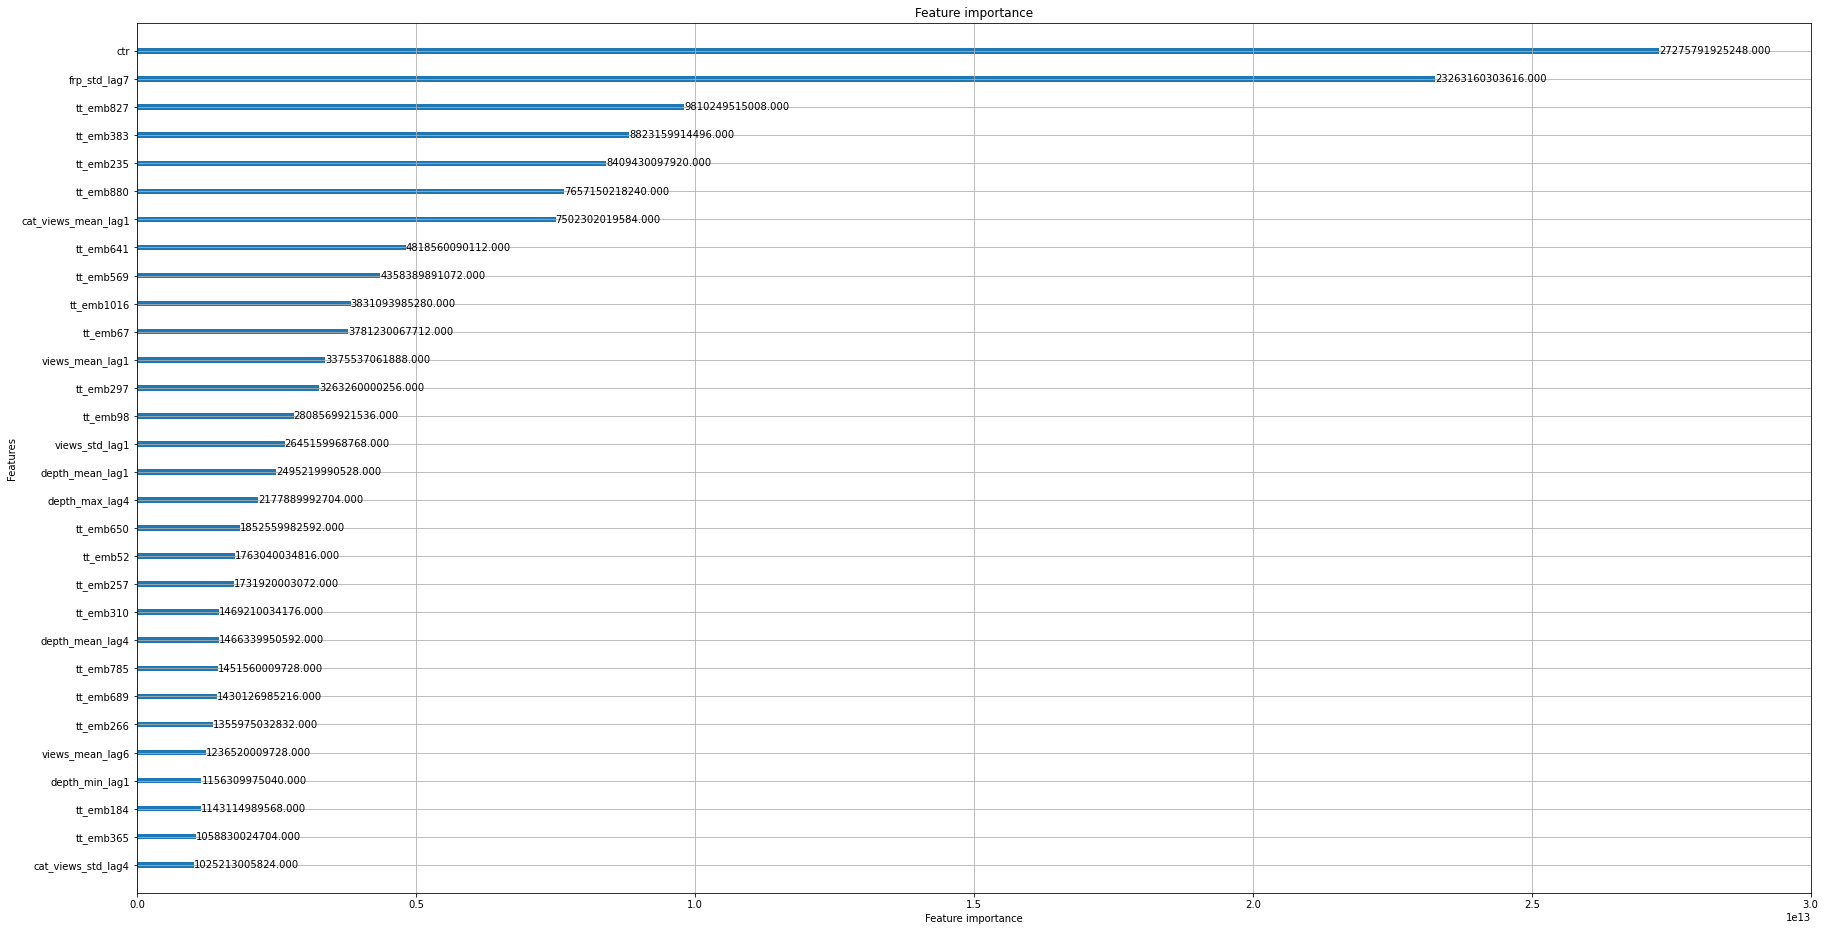

In [18]:
lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

## depth

In [19]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnig_rates': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'random_seed': LGB_RANDOMSEED,
}

In [20]:
# fitting the model
lgb_model_depth = lgb.train(params,
                            train_set=train_ds_depth,
                            valid_sets=val_ds_depth,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnig_rates


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [21]:
# Get predictions and metrics
preds_train_depth = lgb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = lgb_model_depth.predict(x_val[cat_cols + num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8835231811710682, 0.7519392810902077)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

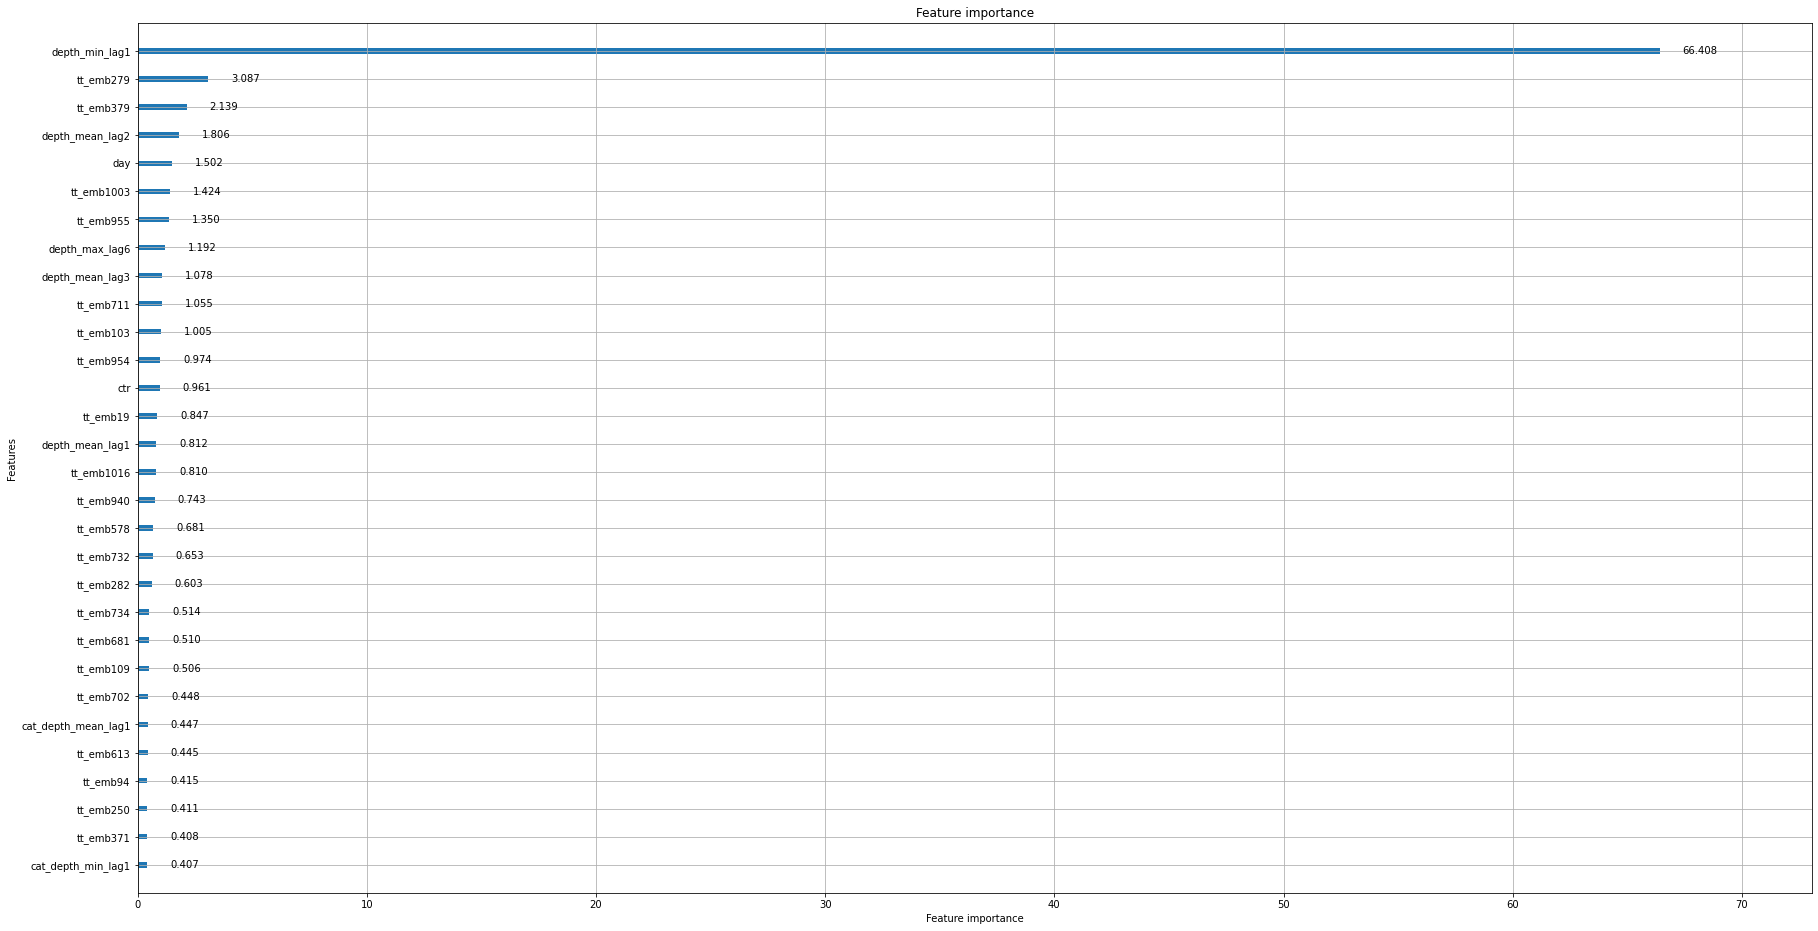

In [22]:
lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [23]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnig_rates': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'random_seed': LGB_RANDOMSEED,
}

In [24]:
# fitting the model
lgb_model_frp = lgb.train(params,
                            train_set=train_ds_frp,
                            valid_sets=val_ds_frp,
                            early_stopping_rounds=30,
                            verbose_eval = False,
                           )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: learnig_rates


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [25]:
# Get predictions and metrics
preds_train_frp = lgb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp  = lgb_model_frp.predict(x_val[cat_cols + num_cols])

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp  = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.5942299501576211, 0.3778378916210692)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

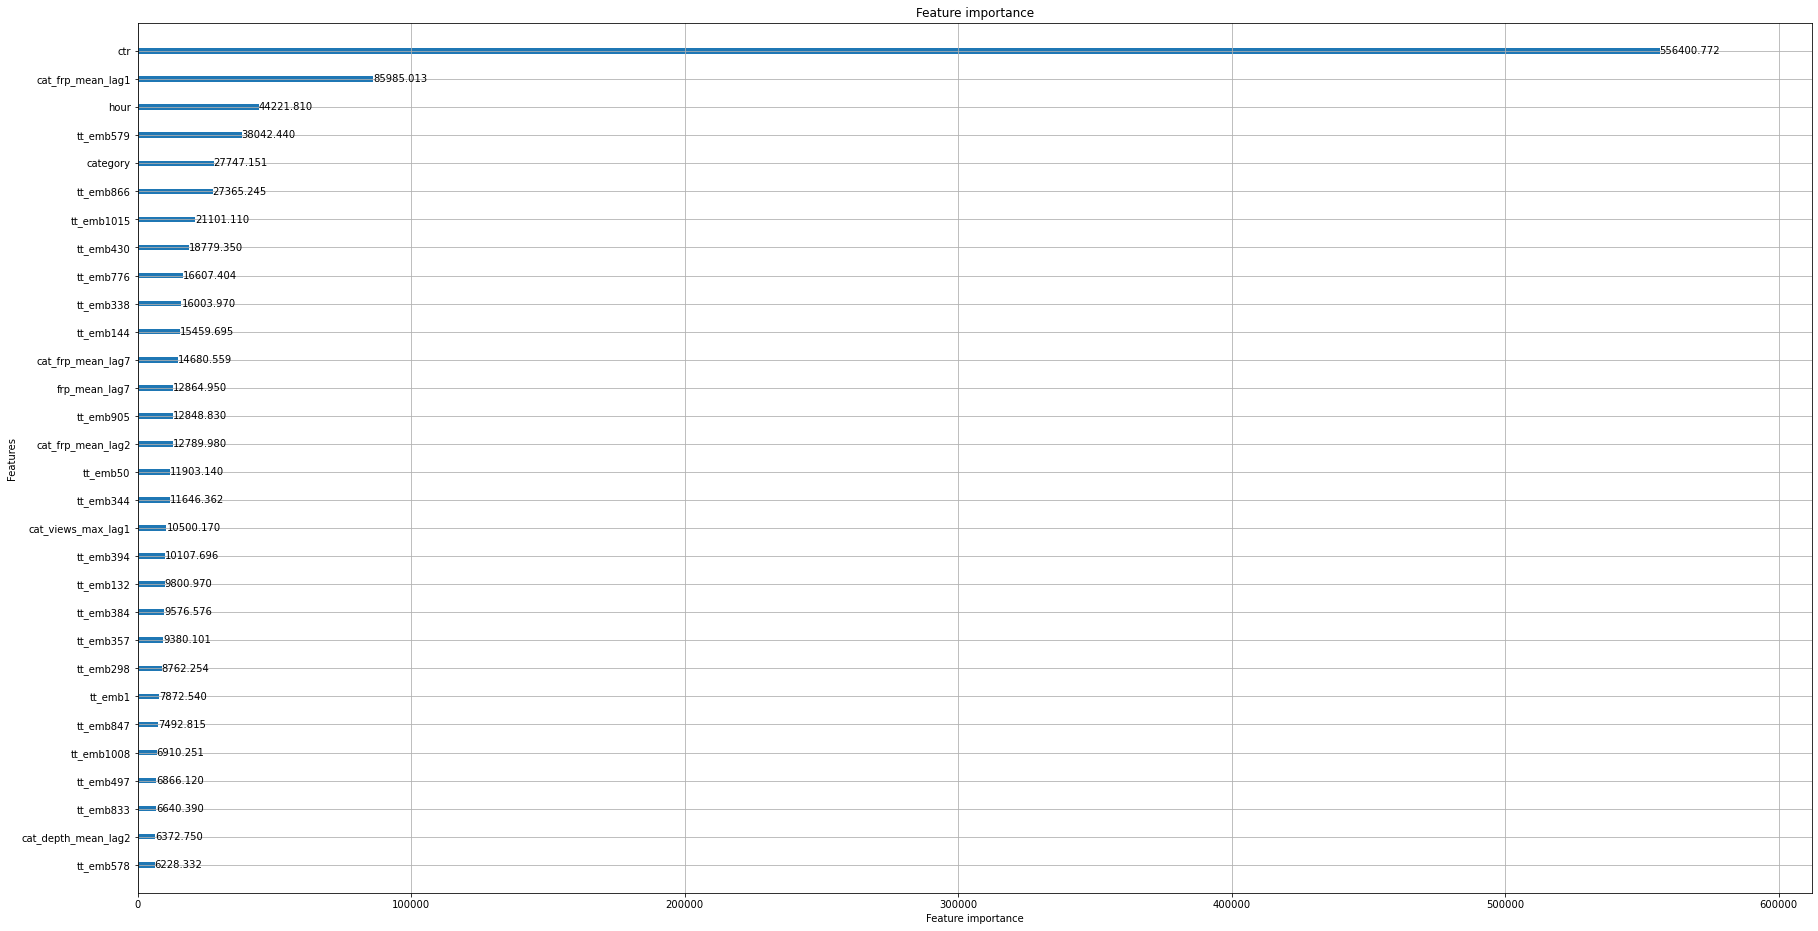

In [26]:
lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [27]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6404491526658227, 0.49230232124914014)

In [28]:
NTRY = 5

## save models

In [29]:
lgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_lgm_views.txt'), num_iteration = lgb_model_views.best_iteration)
lgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_lgm_depth.txt'), num_iteration = lgb_model_depth.best_iteration)
lgb_model_frp.save_model(  os.path.join(DIR_MODELS, f'{NTRY}_lgm_frp.txt'),   num_iteration = lgb_model_frp.best_iteration)

## make predict

In [30]:
pred_views = lgb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = lgb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = lgb_model_frp.predict(  df_test[cat_cols + num_cols])

In [31]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [32]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,21263.835367,1.176169,36.084933
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,14949.754617,1.058042,31.959457
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,14949.754617,1.068498,29.430535
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,14949.754617,1.077715,37.692162
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,363876.558015,1.188798,31.532584


In [33]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_ttl_emb_depth_frp.csv'), index = False)